# Notebook #5: Series temporales: predicción a futuro de la población

In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('../..')
from src import soporte_funciones_BBDD as sfbd
from src import soporte_sarima as ss
from src import soporte_temporales as st
from src import soporte_variables_poblacion as svp

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


# Visualizar las métricas de error en y_test
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

In [2]:
df_poblacion = sfbd.dbeaver_fetch(sfbd.dbeaver_conexion("proyecto_final"),svp.query_poblacion)

In [5]:
df_poblacion.columns = ['FECHA', 'Población']
df_poblacion['FECHA'] = pd.to_datetime(df_poblacion['FECHA'].astype(str) + '-12-31')

In [6]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_poblacion, temporal_column="FECHA", value_column="Población")

analisis_st.exploracion_datos()

El número de filas es 64 y el número de columnas es 1

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Población,64,7329201,2478189,3268336,5146997,7373664,9485026,11331265


In [7]:
analisis_st.comprobar_serie_continua('A')

La serie temporal es continua para la frecuencia 'A', no faltan periodos.


In [8]:
analisis_st.graficar_serie()

## Análisis de la serie temporal del parque vehicular

- Se puede observar una tendencia en ascenso, lo que indica que ha tenido un crecimiento uniforme en el transcurso del tiempo. Sin embargo, entre el 1990-2000 esta línea que muestra un ascenso casi lineal empieza a mostrar un cambio en su fuerza de aumento. Lo cuál queda más claro a partir del 2010.

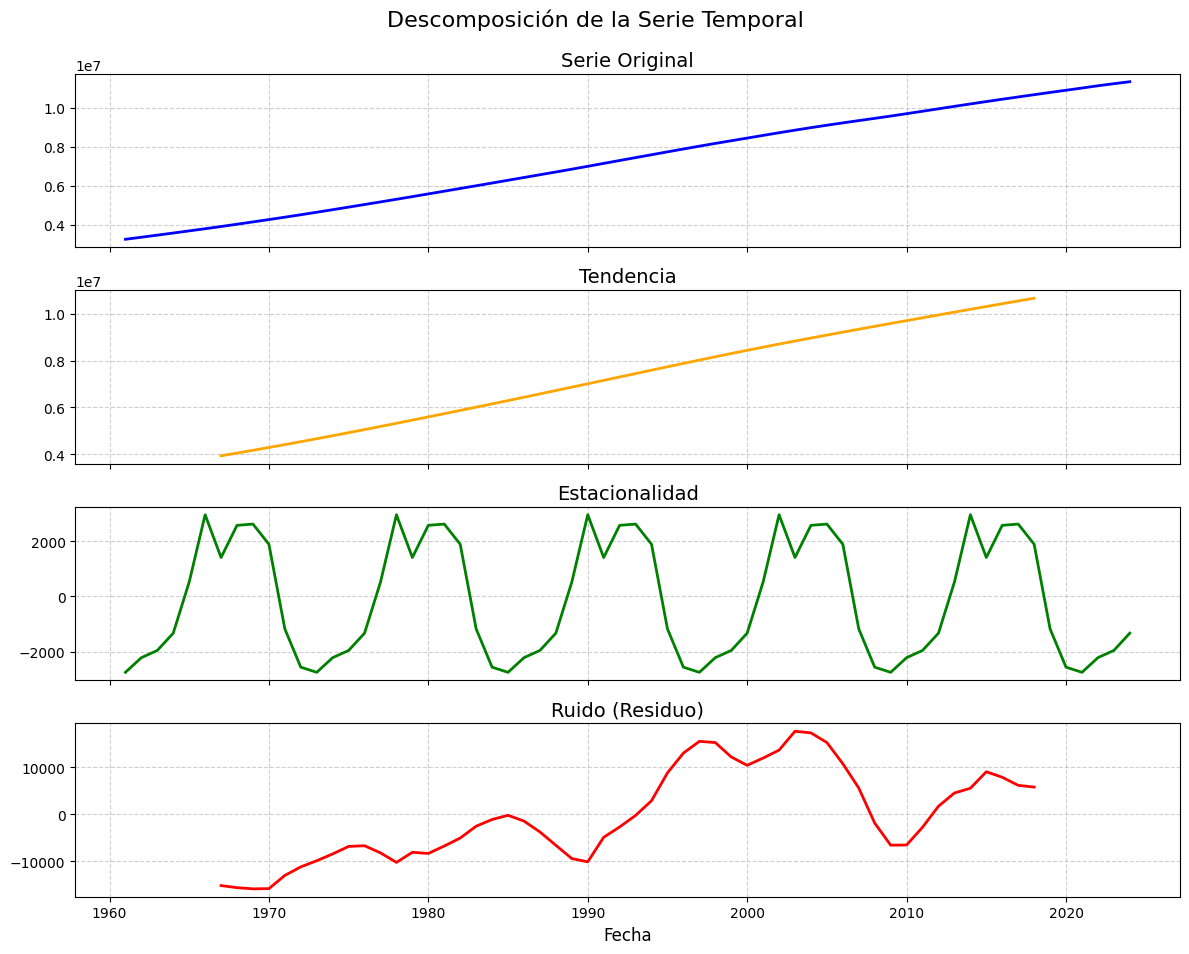

In [9]:
analisis_st.detectar_estacionalidad()

<Figure size 1200x1000 with 0 Axes>

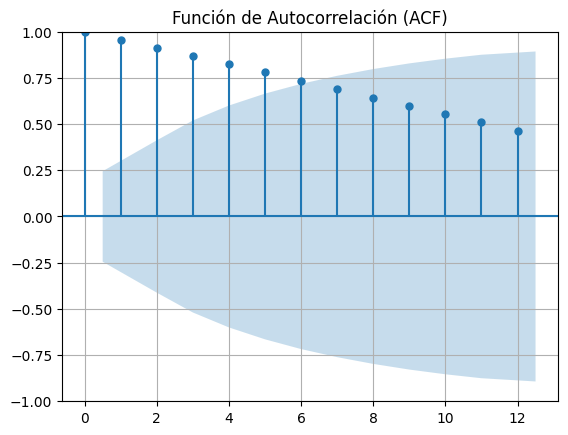

<Figure size 1200x1000 with 0 Axes>

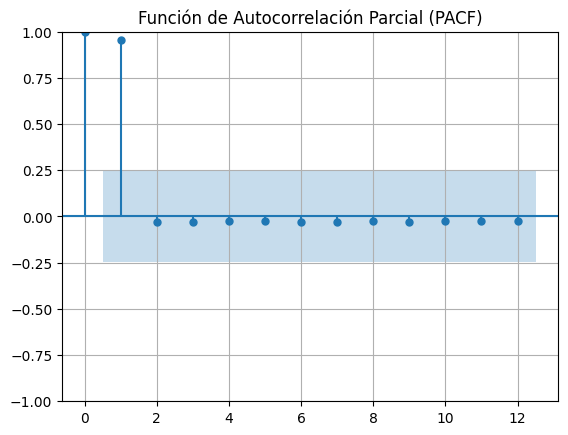

In [10]:
analisis_st.graficar_acf_pacf(lags=12)

## Análisis de las gráficas ACF y PACF

### **Gráfica ACF (Función de Autocorrelación)**
1. **Lag 1**:
   - La correlación en el primer lag es muy alta, lo que indica que la variable tiene una fuerte relación con su valor del periodo inmediatamente anterior.
   
2. **Lags significativos**:
   - Hasta el lag número 6 tienen correlaciones significativas que sobresalen del intervalo de confianza, lo que sugiere que también tienen impacto en la serie.
   - Después del sexto lag, las correlaciones se adentran al intervalo de confianza.

3. **Estacionalidad**:
   - No tiene estacionalidad ya que son datos anuales   
---

### **Gráfica PACF (Función de Autocorrelación Parcial)**
1. **Lag 1**:
   - El primer lag muestra una correlación significativa, indicando que el valor actual está altamente influenciado por el valor del periodo inmediatamente anterior.

2. **Lags significativos**:
   - El segundo lag también tiene una fuerte conexión, sin embargo pasado este todos caen dentro del intervalo de confianza. De manera que los lags más lejanos no tienen influencia directa significativa.
---

In [11]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -3.7268586635941947
p-value: 0.0037508380967098305
Valores Críticos:
1%: -3.548493559596539
5%: -2.912836594776334
10%: -2.594129155766944
Rechazamos la hipótesis nula. La serie es estacionaria.


In [12]:
modelo_arima = st.ARIMAModel()

parametros_arima = modelo_arima.generar_parametros(p_range=range(1,6), q_range=range(1,6))
parametros_arima[:5]

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

In [13]:
train_size= int(0.7 * len(df_poblacion))
df_poblacion.set_index('FECHA', inplace=True)
df_poblacion.index = pd.to_datetime(df_poblacion.index)
df_poblacion = df_poblacion.asfreq('A')

y_train, y_test = df_poblacion[:train_size], df_poblacion[train_size:]

In [14]:
resultados_arima = modelo_arima.evaluar_modelos(y_train, y_test, parametros_arima, diferenciacion=1)
resultados_arima.head(3)

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  4%|▍         | 1/25 [00:00<00:09,  2.54it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  8%|▊         | 2/25 [00:00<00:11,  2.03it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 12%|█▏        | 3/25 [00:01<00:16,  1.36it/s]C:\Users\DELL\AppData\Local\Packages\Pyth

,p,q,RMSE,error
0,1,1,157572,NaN
1,1,2,162829,NaN
2,1,3,164911,NaN


In [15]:
resultados_arima.head().sort_values(by='RMSE', ascending=True)

,p,q,RMSE,error
0,1,1,157572,NaN
3,1,4,161879,NaN
1,1,2,162829,NaN
2,1,3,164911,NaN
4,1,5,2868863,NaN


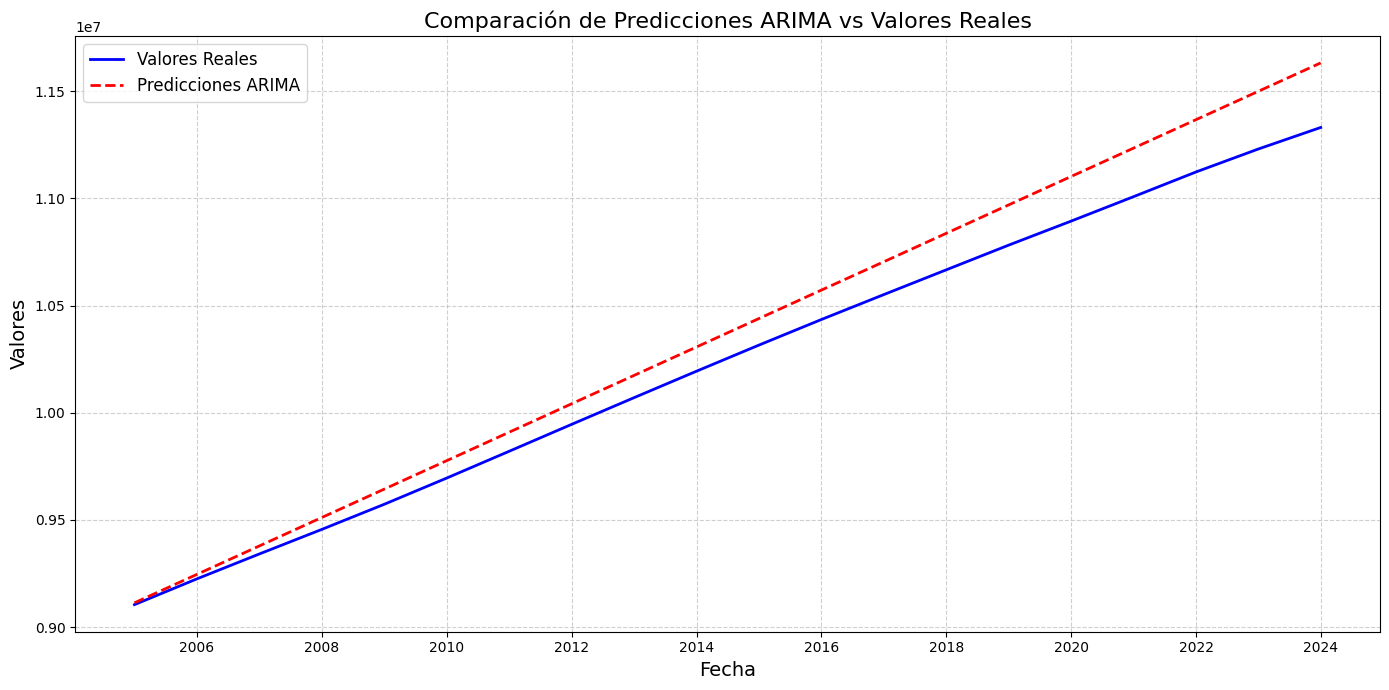

In [16]:
modelo_arima.visualizar_predicciones(y_test)

In [17]:
modelo_arima.best_model['pred_test']

FECHA
2004-12-31    9113271
2005-12-31    9245916
2006-12-31    9378556
2007-12-31    9511189
2008-12-31    9643815
2009-12-31    9776436
2010-12-31    9909051
2011-12-31   10041660
2012-12-31   10174262
2013-12-31   10306859
2014-12-31   10439449
2015-12-31   10572034
2016-12-31   10704612
2017-12-31   10837184
2018-12-31   10969751
2019-12-31   11102311
2020-12-31   11234865
2021-12-31   11367413
2022-12-31   11499955
2023-12-31   11632491
Freq: A-DEC, Name: predicted_mean, dtype: float64

In [18]:
modelo_arima.best_params

{'p': 1, 'q': 1}

### Métricas para el y_test

In [19]:
# Calcular métricas
mae = mean_absolute_error(y_test, modelo_arima.best_model["pred_test"])
mape = mean_absolute_percentage_error(y_test, modelo_arima.best_model["pred_test"])
rmse = np.sqrt(mean_squared_error(y_test, modelo_arima.best_model["pred_test"]))

print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse}")

MAE: 134868.86458969506
MAPE: 1.27%
RMSE: 157571.61838349255


## Métricas para el conjunto completo

In [20]:
# Entrenar el modelo ARIMA con los mejores parámetros en toda la serie histórica
mejor_modelo_arima = ARIMA(
    pd.concat([y_train, y_test]),  # Usar toda la serie
    order=(2, 1, 6)  # Incluir el parámetro `d=1` o el que hayas usado
).fit()

mejor_modelo_arima.summary()

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Población   No. Observations:                   64
Model:                 ARIMA(2, 1, 6)   Log Likelihood               -9461.995
Date:                Fri, 31 Jan 2025   AIC                          18941.990
Time:                        16:37:39   BIC                          18961.279
Sample:                    12-31-1960   HQIC                         18949.577
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0658   8.93e-05    736.938      0.000       0.066       0.066
ar.L2          0.9341   8.06e-05   1.16e+04      0.000       0.934       0.934
ma.L1         -0.0543      0.000   -202.092      0.000      -0.055      -0.054
ma.L2         -0.9555      0.001  -1133.268      0.000      -0.957      -0.954
ma.L3          0.0116    3.9e-05    298.597      0.000       0.012       0.012
ma.L4         -0.0072      0.001     -9.086      0.000      -0.009      -0.006
ma.L5          0.0126   3.59e-05    351.936      0.000       0.013       0.013
ma.L6         -0.0030   7.32e-05    -41.438      0.000      -0.003      -0.003
sigma2      3.351e+06   1.38e-11   2.43e+17      0.000    3.35e+06    3.35e+06
===================================================================================
Ljung-Box (L1) (Q):                  27.26   Jarque-Bera (JB):                 1.28
Prob(Q):                              0.00   Prob(JB):                         0.53
Heteroskedasticity (H):               0.24   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.66e+31. Standard errors may be unstable.
"""

In [21]:
pred_todo = mejor_modelo_arima.predict(start=0, end=len(y_test) + len(y_train) - 1)
pred_df = pd.DataFrame({
    "Fecha": pd.concat([y_train, y_test]).index,
    "Valor Real": pd.concat([y_train, y_test])["Población"],
    "Predicción": pred_todo
})
pred_df

,Fecha,Valor Real,Predicción
FECHA,,,
1960-12-31,1960-12-31,3268336,0
1961-12-31,1961-12-31,3373233,3416273
1962-12-31,1962-12-31,3479936,3479139
1963-12-31,1963-12-31,3588287,3650521
1964-12-31,1964-12-31,3698559,3678022
...,...,...,...
2019-12-31,2019-12-31,10894043,10924422
2020-12-31,2020-12-31,11008300,11018266
2021-12-31,2021-12-31,11123476,11149651


In [22]:
# Calcular métricas
mae_todo = mean_absolute_error(pred_df["Valor Real"], pred_df["Predicción"])
mape_todo = mean_absolute_percentage_error(pred_df["Valor Real"], pred_df["Predicción"])
rmse_todo = np.sqrt(mean_squared_error(pred_df["Valor Real"], pred_df["Predicción"]))

# Mostrar resultados
print(f"MAE para toda la serie: {mae_todo}")
print(f"MAPE para toda la serie: {mape_todo * 100:.2f}%")
print(f"RMSE para toda la serie: {rmse_todo}")

MAE para toda la serie: 77158.4132245483
MAPE para toda la serie: 2.02%
RMSE para toda la serie: 409724.5525400153


## Métricas sin el primer año

In [23]:
# Calcular métricas
mae_todo = mean_absolute_error(pred_df["Valor Real"][1:], pred_df["Predicción"][1:])
mape_todo = mean_absolute_percentage_error(pred_df["Valor Real"][1:], pred_df["Predicción"][1:])
rmse_todo = np.sqrt(mean_squared_error(pred_df["Valor Real"][1:], pred_df["Predicción"][1:]))

# Mostrar resultados
print(f"MAE para toda la serie: {mae_todo}")
print(f"MAPE para toda la serie: {mape_todo * 100:.2f}%")
print(f"RMSE para toda la serie: {rmse_todo}")

MAE para toda la serie: 26504.80073604908
MAPE para toda la serie: 0.46%
RMSE para toda la serie: 31352.87236971861


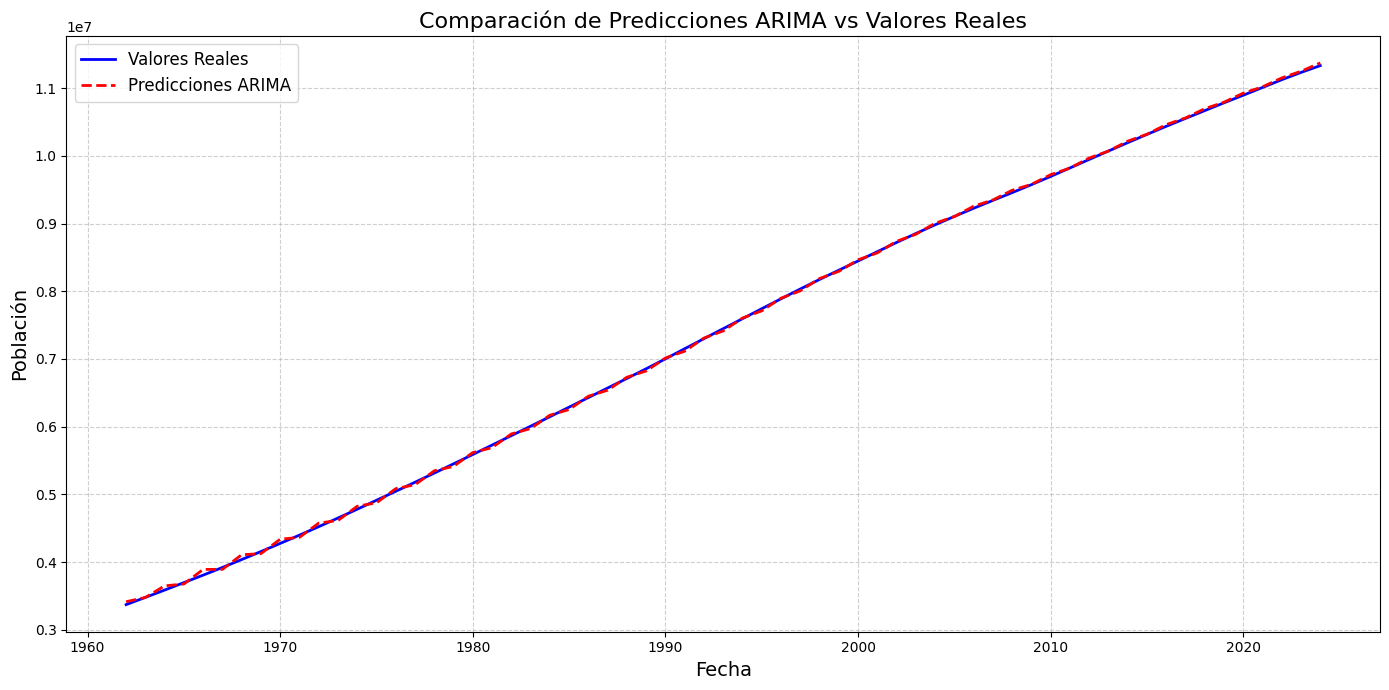

In [24]:
# Configuración de la figura
plt.figure(figsize=(14, 7))

# Graficar valores reales
sns.lineplot(data=pred_df[1:], x="Fecha", y="Valor Real", label="Valores Reales", color="blue", linewidth=2)

# Graficar predicciones
sns.lineplot(data=pred_df[1:], x="Fecha", y="Predicción", label="Predicciones ARIMA", color="red", linestyle="--", linewidth=2)

# Personalización de la gráfica
plt.title("Comparación de Predicciones ARIMA vs Valores Reales", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Población", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

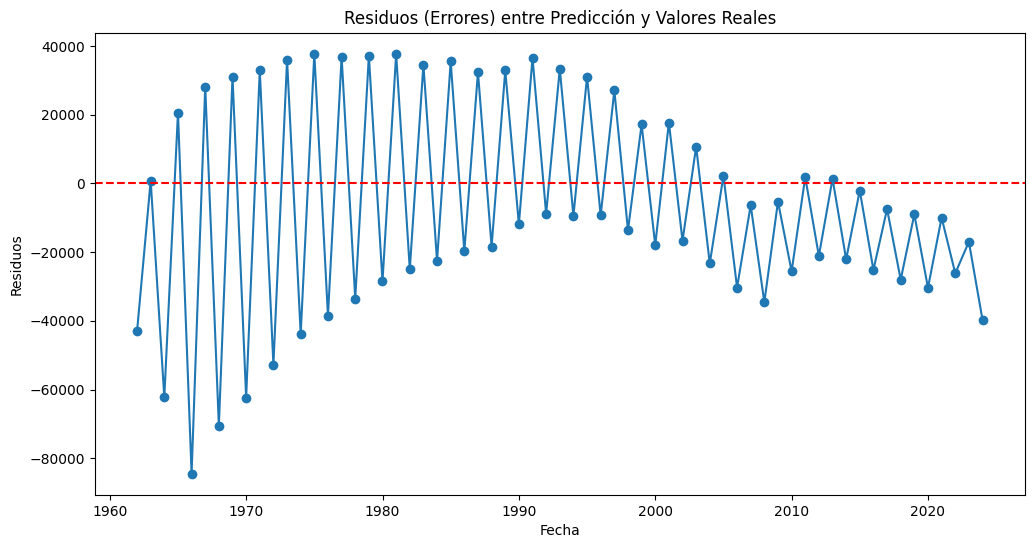

In [25]:
residuos = pred_df["Valor Real"] - pred_df["Predicción"]
plt.figure(figsize=(12, 6))
plt.plot(pred_df["Fecha"][1:], residuos[1:], marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuos (Errores) entre Predicción y Valores Reales")
plt.xlabel("Fecha")
plt.ylabel("Residuos")
plt.show()

## Aplicar mejores parámetros y predecir

In [26]:
mejor_modelo_arima = ARIMA(
    pd.concat([y_train, y_test]),  # Usar toda la serie
    order=(2, 1, 6)  
).fit()

print(mejor_modelo_arima.summary())

                               SARIMAX Results                                
Dep. Variable:              Población   No. Observations:                   64
Model:                 ARIMA(2, 1, 6)   Log Likelihood               -9461.995
Date:                Fri, 31 Jan 2025   AIC                          18941.990
Time:                        16:37:44   BIC                          18961.279
Sample:                    12-31-1960   HQIC                         18949.577
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0658   8.93e-05    736.938      0.000       0.066       0.066
ar.L2          0.9341   8.06e-05   1.16e+04      0.000       0.934       0.934
ma.L1         -0.0543      0.000   -202.092      0.0

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Utilicé el parámetro, d=2, porque al utilizar 1 como valor todas las predicciones eran iguales.

In [27]:
# Predecir los próximos 2 años (por ejemplo)
predicciones_futuras = mejor_modelo_arima.predict(start=len(y_train) + len(y_test), 
                                                  end=len(y_train) + len(y_test) + 2)
print(predicciones_futuras)

2024-12-31   11455310
2025-12-31   11594856
2026-12-31   11719279
Freq: A-DEC, Name: predicted_mean, dtype: float64


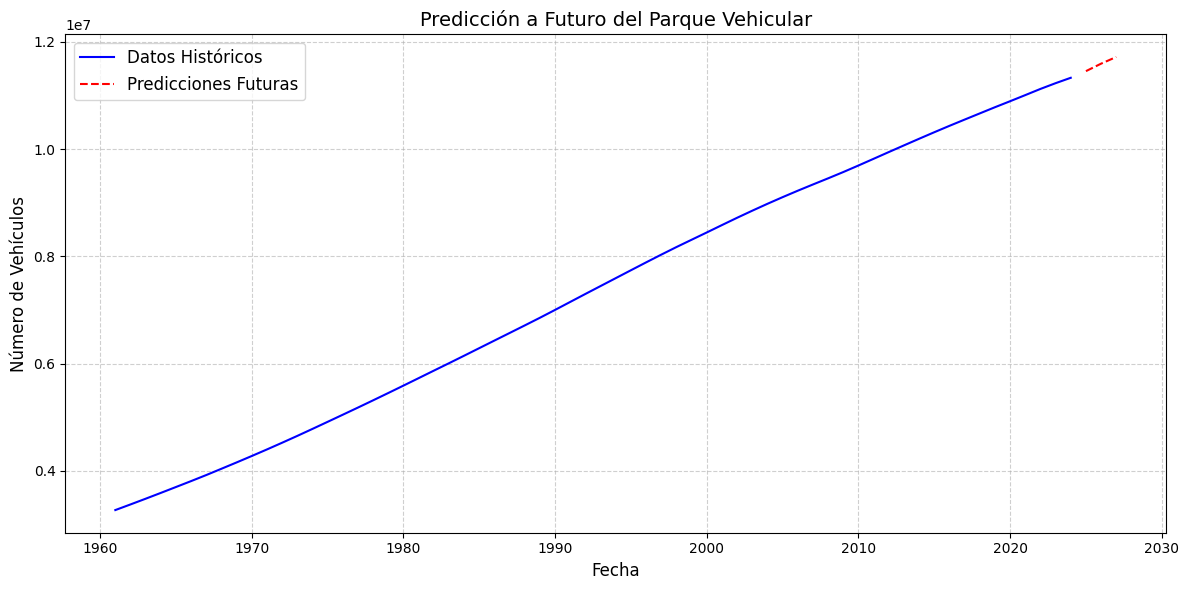

In [28]:
# Crear un rango de fechas para las predicciones futuras
fechas_futuras = pd.date_range(start=y_test.index[-1] + pd.DateOffset(1), periods=len(predicciones_futuras), freq='A')

# Crear un DataFrame para las predicciones futuras
predicciones_df = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Predicción': predicciones_futuras
})

# Unir las predicciones futuras con los datos históricos
datos_historicos_df = pd.concat([y_train, y_test])
datos_historicos_df = pd.DataFrame(datos_historicos_df).reset_index()
datos_historicos_df.columns = ['Fecha', 'Valor Real']

# Graficar los datos
plt.figure(figsize=(12, 6))

# Graficar datos históricos
plt.plot(datos_historicos_df['Fecha'], datos_historicos_df['Valor Real'], label='Datos Históricos', color='blue')

# Graficar predicciones futuras
plt.plot(predicciones_df['Fecha'], predicciones_df['Predicción'], label='Predicciones Futuras', color='red', linestyle='--')

# Personalizar el gráfico
plt.title('Predicción a Futuro del Parque Vehicular', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Vehículos', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Mostrar el gráfico
plt.show()